# Cognitive Modelling: Study on Effect of Temporal Context in a Timing Task

**Varun Ravi Varma, *S3893030***

In [1]:
from model import Model
from chunk import Chunk
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import math

plt.rcParams.update({'font.size': 22})

### Generating data based on the experimental design

In [2]:
def generate_data(block, bias=None):
    sample_dur = [1165, 1265, 1395, 1535, 1675]
    if block == 1:
        reps = [16, 16, 16, 16, 16]
    else:
        if bias == "long":
            reps = [12, 12, 12, 12, 32]
        elif bias == "short":
            reps = [32, 12, 12, 12, 12]

    signal_times = []
    for duration, count in zip(sample_dur, reps):
        for i in range(count):
            signal_times.append(duration)
    
    np.random.shuffle(signal_times)

    return signal_times

### Time perception functions

**Noise Function**

In [3]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

**Time to Pulses Function**

In [4]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

**Pulses to Time Function**

In [5]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

### Defining the Model

In [6]:
def single_expt(subj_id, time_signals, block, condition, model):
    op = []
    # Repeat the experiment for each time preset in the experiment setup
    for time in time_signals:
        ts = time/1000
        
        # Adding Inter-trial time
        model.time += 2.75 + np.random.uniform(0,0.50)

        # Adding the time (as a pulse signature) to a chunk with condition and trial information as name
        model.time += ts
        pulse_ts = time_to_pulses(ts)
        model.add_encounter(Chunk(str(subj_id)+str(block)+str(pulse_ts), slots={"type": "numbers", "pulse": pulse_ts}))

        # Adding the stimulus time interval to the model time
        model.time += 0.70 + np.random.uniform(0, 0.20)

        # Blending previous experiences
        blend_data = Chunk(name="blend", slots={})

        # Retrieving blended experience and updating time
        retrieve_blend = model.retrieve_blended_trace(blend_data, "pulse")
        tp = pulses_to_time(retrieve_blend[0])

        model.time += tp
        op.append([subj_id, block, condition, ts*1000, tp*1000])
        
    return op

## Experiment stage
Running the experiment for 80 agents with 40 agents per bias. Each agent performs block 1 and either bias of block 2 (short or long)

In [7]:
# Storing the output in a dataframe
conditions = ["short", "long"]
exp_output = []

for subj_id in range(80):
    # Instantiate a participant
    mod = Model()
    
    # generating unique subject IDs since each subject only performs in long or short trials and never both
    if np.mod(subj_id, 2) != 0:
        # ODD Numbered subjects perform SHORT trials
        condition = "short"
        
        # Simulate block 1 for the participant
        time_signals = generate_data(1)
        exp_output += single_expt(subj_id, time_signals, 1, condition, mod)

        # Adding the interval between blocks: 2 minutes
        mod.time += 120000

        # Simulate block 2 for the participant
        time_signals = generate_data(2, bias=condition)
        exp_output += single_expt(subj_id, time_signals, 2, condition, mod)
        
    else:
        # EVEN Numbered subjects perform LONG trials
        condition = "long"
        
        # Simulate block 1 for the participant
        time_signals = generate_data(1)
        exp_output += single_expt(subj_id, time_signals, 1, condition, mod)

        # Adding the interval between blocks: 2 minutes
        mod.time += 120000

        # Simulate block 2 for the participant
        time_signals = generate_data(2, bias=condition)
        exp_output += single_expt(subj_id, time_signals, 2, condition, mod)
    
results = pd.DataFrame(exp_output, columns=["Subj_Id", "Block", "Cond", "Ts", "Tp"])
        

        

## Plotting the results obtained from the simulation of the experiment

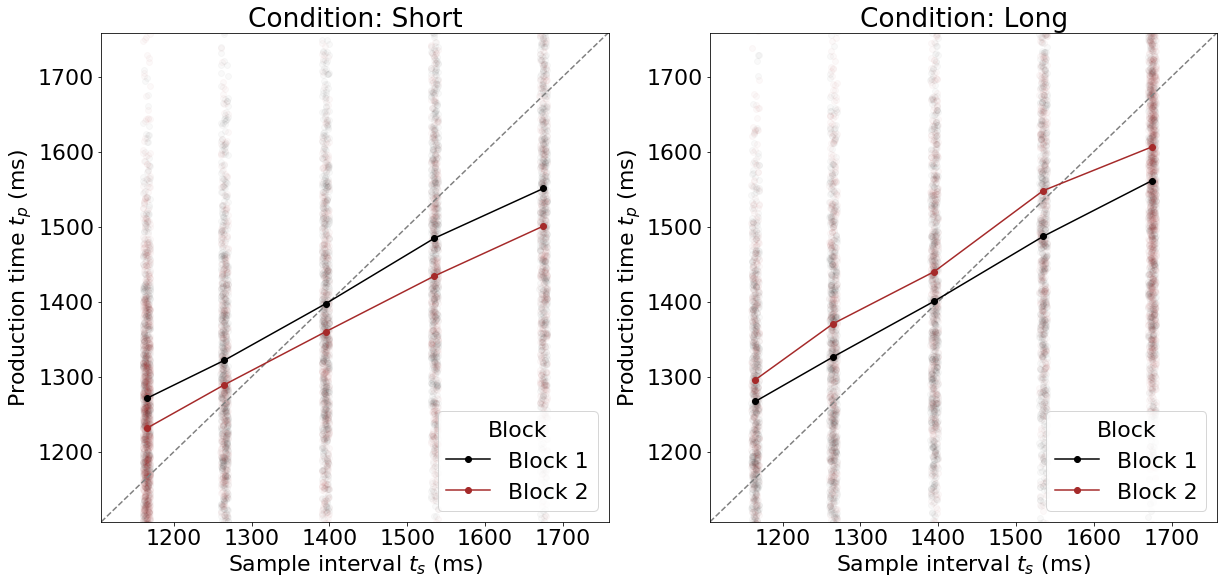

In [8]:
jitter = results.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(results))
jitter_short = jitter[jitter["Cond"] == "short"]
jitter_long = jitter[jitter["Cond"] == "long"]
short_filtered = results[results["Cond"] == "short"]
long_filtered = results[results["Cond"] == "long"]

mean_short = short_filtered.groupby(['Block', 'Ts'])['Tp'].mean().reset_index()
mean_long = long_filtered.groupby(['Block', 'Ts'])['Tp'].mean().reset_index()

yrange = np.multiply((min(short_filtered['Ts']), max(long_filtered['Ts'])), [0.95, 1.05])


f, axs = plt.subplots(1, 2, figsize = (20,9))
# f.gca().set_aspect('equal', adjustable = 'box')

block_1_short = mean_short.loc[mean_short['Block'] == 1]
block_2_short = mean_short.loc[mean_short['Block'] == 2]
jitter_1_short = jitter_short.loc[jitter_short["Block"] == 1]
jitter_2_short = jitter_short.loc[jitter_short["Block"] == 2]

axs[0].set(xlim = yrange, ylim = yrange, title="Condition: Short")

axs[0].set_xlabel(r'Sample interval $t_{s}$ (ms)')
axs[0].set_ylabel(r'Production time $t_{p}$ (ms)')

axs[0].plot(yrange, yrange, linestyle = '--', color ='gray')

axs[0].plot(block_1_short['Ts'], block_1_short['Tp'], color = 'black', marker = 'o', label = "Block 1")
axs[0].plot(block_2_short['Ts'], block_2_short['Tp'], color = 'brown', marker = 'o', label = "Block 2")
axs[0].scatter(jitter_1_short['Ts'], jitter_1_short['Tp'], color = 'black', marker = 'o', alpha = 0.025, label = None)
axs[0].scatter(jitter_2_short['Ts'], jitter_2_short['Tp'], color = 'brown', marker = 'o', alpha = 0.025, label = None)



axs[0].legend(title = 'Block', loc = 4)


block_1_long = mean_long.loc[mean_long['Block'] == 1]
block_2_long = mean_long.loc[mean_long['Block'] == 2]
jitter_1_long = jitter_long.loc[jitter_long["Block"] == 1]
jitter_2_long = jitter_long.loc[jitter_long["Block"] == 2]

axs[1].set(xlim = yrange, ylim = yrange, title="Condition: Long")

axs[1].set_xlabel(r'Sample interval $t_{s}$ (ms)')
axs[1].set_ylabel(r'Production time $t_{p}$ (ms)')

axs[1].plot(yrange, yrange, linestyle = '--', color ='gray')

axs[1].plot(block_1_long['Ts'], block_1_long['Tp'], color = 'black', marker = 'o', label = "Block 1")
axs[1].plot(block_2_long['Ts'], block_2_long['Tp'], color = 'brown', marker = 'o', label = "Block 2")
axs[1].scatter(jitter_1_long['Ts'], jitter_1_long['Tp'], color = 'black', marker = 'o', alpha = 0.025, label = None)
axs[1].scatter(jitter_2_long['Ts'], jitter_2_long['Tp'], color = 'brown', marker = 'o', alpha = 0.025, label = None)




axs[1].legend(title = 'Block', loc = 4)

